# CS6700: Reinforcement Learning
## Programming Assignment 3

Submitted by:
- Archish S (ME20B032)
- Vinayak Gupta (EE20B152)

# Semi-Markov Decision Process

## Imports

In [1]:
import io
import glob
import random
from dataclasses import dataclass
from collections import deque
from itertools import count

import gym
from gym import wrappers
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 10
})
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
%config InlineBackend.figure_format = 'retina'

import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

## Environment

In [2]:
env = gym.make('Taxi-v3')
state = env.reset()

# Current State
print("Current State:", env.s)

# Observation Space
locations = ["red", "green", "yellow", "blue"]
print ("Number of states:", env.observation_space.n)

# Action Space
actions = ["south", "north", "east", "west", "pick", "drop"]
print ("Number of actions:", env.action_space.n)

# Transition 
action = random.randint(0, len(actions)-1)
next_state, reward, done, info = env.step(action)
print("Action:", actions[action])
print("Next State:", next_state)
print("Reward:", reward)
print("Done:", done)

print("Decoded Current State:", list(env.decode(state)))
print("Decoded Next State:", list(env.decode(next_state)))

Current State: 387
Number of states: 500
Number of actions: 6
Action: west
Next State: 367
Reward: -1
Done: False
Decoded Current State: [3, 4, 1, 3]
Decoded Next State: [3, 3, 1, 3]


In [3]:
def get_grid():
    plt.figure(figsize=(5, 5))
    grid = np.zeros((5, 5)).astype(int)
    grid[0, 0] = 1
    grid[0, 4] = 2
    grid[4, 0] = 3
    grid[4, 3] = 4

    colors = ['white', 'red', 'green', 'yellow', 'blue']
    cmap = plt.cm.colors.ListedColormap(colors)

    plt.imshow(grid, cmap=cmap, interpolation='nearest', alpha=0.5)

    plt.axvline(x=0.5, ymin=0, ymax=2/5, color='black', linewidth=2)
    plt.axvline(x=2.5, ymin=0, ymax=2/5, color='black', linewidth=2)
    plt.axvline(x=1.5, ymin=3/5, ymax=1, color='black', linewidth=2)
    plt.axvline(x=0.5, color='black', linewidth=0.5)
    plt.axvline(x=1.5, color='black', linewidth=0.5)
    plt.axvline(x=2.5, color='black', linewidth=0.5)
    plt.axvline(x=3.5, color='black', linewidth=0.5)
    plt.axvline(x=4.5, color='black', linewidth=0.5)

    plt.axhline(y=0.5, color='black', linewidth=0.5)
    plt.axhline(y=1.5, color='black', linewidth=0.5)
    plt.axhline(y=2.5, color='black', linewidth=0.5)
    plt.axhline(y=3.5, color='black', linewidth=0.5)
    plt.axhline(y=4.5, color='black', linewidth=0.5)

    plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

## Parameters

In [4]:
max_runs = 5
max_episodes = 5000
# max_steps = 1000

epsilon_max = 0.99
epsilon_min = 0.01

gamma = 0.9
alpha = 0.1

nX = 5; nY = 5; nPas = 5; nDrop = 4
nS = nX * nY * nPas * nDrop

targets = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
actions_map = {0: "\u2193", 1: "\u2191", 2: "\u2192", 3: "\u2190", 4: "P", 5: "D", 6: "R", 7: "G", 8: "Y", 9: "B"}
nO = 4
nA = 6

assert nS == env.observation_space.n
assert nA == env.action_space.n

## Policy

In [5]:
def egreedy_policy(q_values, state, epsilon):
    if q_values[state].any() and random.random() > epsilon:
        return np.argmax(q_values[state])

    choice = random.randint(0, q_values.shape[-1] - 1)  
    return choice

In [6]:
def substate(state):
    x, y, p, d = env.decode(state)
    return x * nX + y

In [7]:
def Option(env, state, Q, goal, epsilon=0.1):
    optdone, optact = False, None
    x, y, pas, drop = env.decode(state)

    if (x == targets[goal][0] and y == targets[goal][1]):
        optdone = True 
        if pas == goal:
            optact = 4
        elif drop == goal:
            optact = 5 
        else:   
            optact = 1 if (goal in [0, 1]) else 0
    else:
        option_state = substate(state)
        optact = egreedy_policy(Q, option_state, epsilon=epsilon) 

    return [optact, optdone]

# SMDP Q-Learning

In [8]:
Q_SMDP = np.zeros((max_runs, nX * nY, nA + nO))
Q_SMDP_Options = dict([(i, np.zeros((max_runs, nX * nY, nA - 2))) for i in range(nO)])

updates_SMDP = []

run_rewards = []
for run in range(max_runs):

    episode_updates = []
    episode_rewards = []
    for episode in range(max_episodes):
        state = env.reset()
        done = False
        
        step_updates = []
        step_rewards = 0
        step = 0
        while not done:
            epsilon = max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * episode / max_episodes)

            substate_current = substate(state)
            action = egreedy_policy(Q_SMDP[run], substate_current, epsilon=epsilon)

            if action in [0, 1, 2, 3, 4, 5]:
                substate_current = substate(state)

                next_state, reward, done, info = env.step(action)
                substate_next = substate(next_state)

                Q_SMDP[run, substate_current, action] = Q_SMDP[run, substate_current, action] + alpha * (reward + gamma * np.max(Q_SMDP[run, substate_next]) - Q_SMDP[run, substate_current, action])
                
                step_rewards += reward
                step_updates.append(step)
                step += 1

                state = next_state

            else:
                start = state
                substate_start = substate(start)
                goal = action - 6

                optrewards = []
                optdone, optsteps = False, 0

                while not optdone:
                    substate_current = substate(state)

                    optact, optdone = Option(env, state, Q_SMDP_Options[goal][run], goal, epsilon=epsilon)
                    next_state, reward, done, info = env.step(optact)
                    substate_next = substate(next_state)

                    if not optdone:
                        Q_SMDP_Options[goal][run, substate_current, optact] = Q_SMDP_Options[goal][run, substate_current, optact] + alpha * (reward + gamma * np.max(Q_SMDP_Options[goal][run, substate_next]) - Q_SMDP_Options[goal][run, substate_current, optact])

                    optrewards.append(gamma**optsteps * reward)
                    optsteps += 1
                    state = next_state

                optrewards = sum(optrewards)
                Q_SMDP[run, substate_start, action] = Q_SMDP[run, substate_start, action] + alpha * (optrewards - gamma**optsteps * np.max(Q_SMDP[run, substate_next]) - Q_SMDP[run, substate_start, action])

                step_rewards += optrewards
                step_updates.append(step + optsteps)
                step += optsteps


        episode_rewards.append(step_rewards)
        episode_updates.append(step_updates)

        clear_output(wait=True)
        print(f"Run: {run+1}/{max_runs}, Episode: {episode+1}/{max_episodes}: {step_rewards}")

    run_rewards.append(episode_rewards)
    updates_SMDP.append(episode_updates)

Q_SMDP = np.mean(Q_SMDP, axis=0)
Q_SMDP_Options = dict([(i, np.mean(Q_SMDP_Options[i], axis=0)) for i in range(nO)])

Run: 5/5, Episode: 5000/5000: -197.6953279


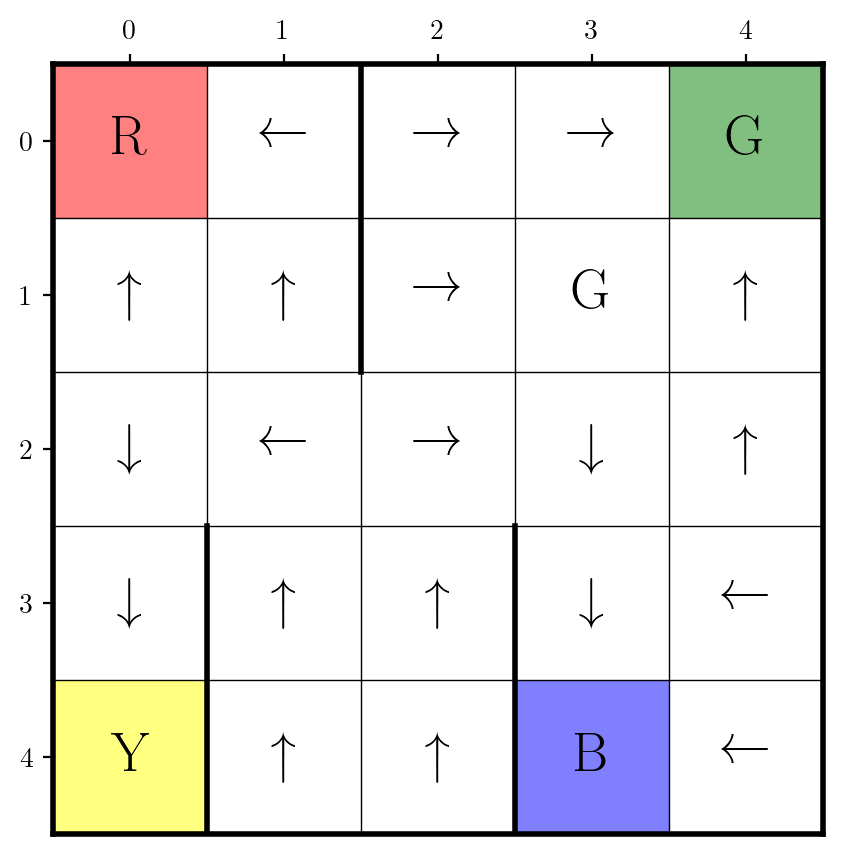

In [9]:
plot_Q = Q_SMDP

get_grid()
for i in range(nX):
    for j in range(nY):
        action = np.argmax(plot_Q[i * nX + j])
        plt.text(j, i, actions_map[action], ha='center', va='center', fontsize=20)

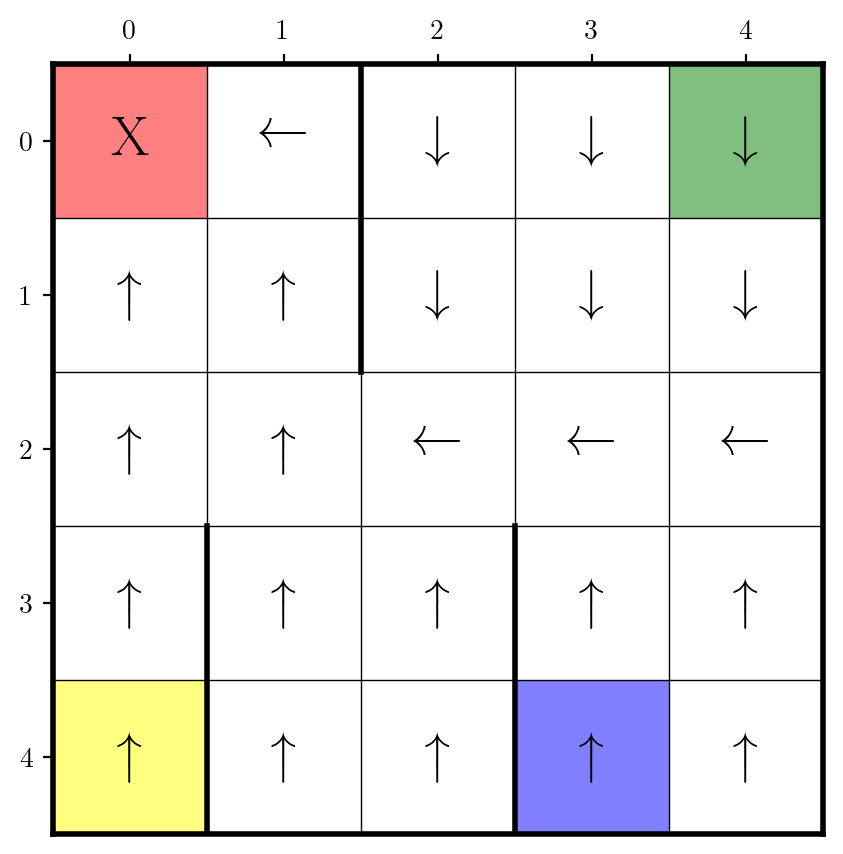

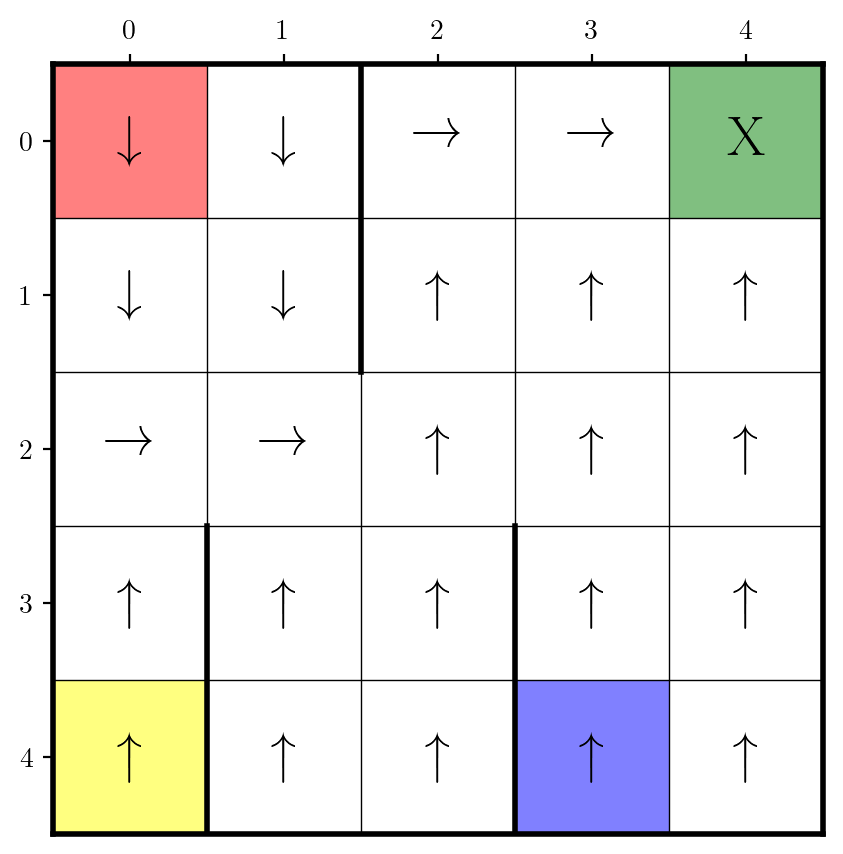

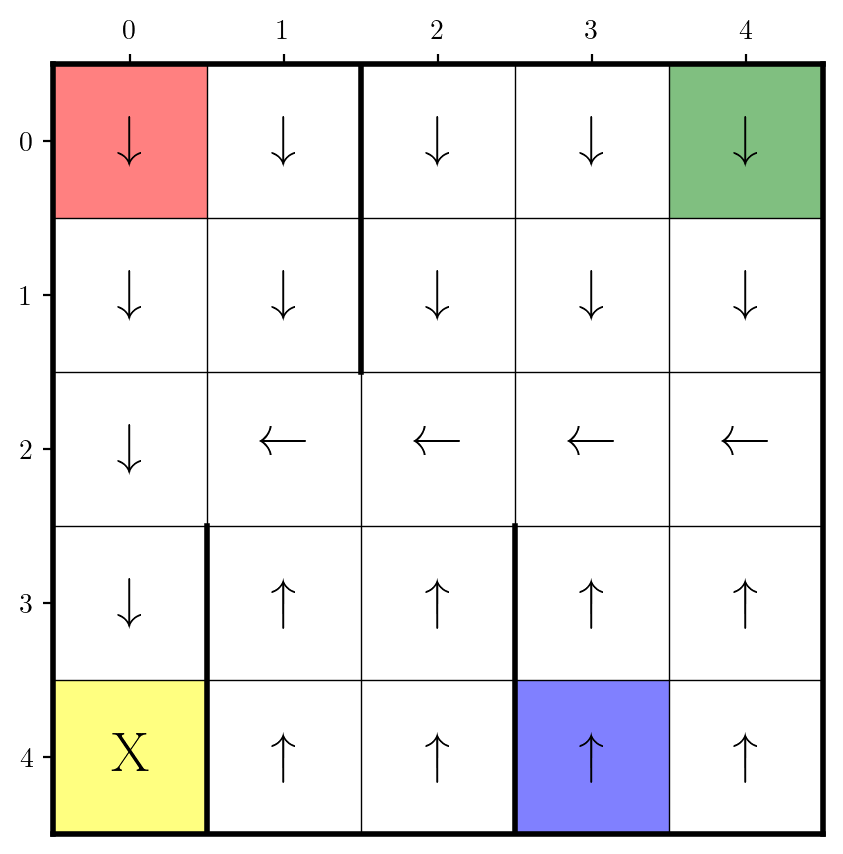

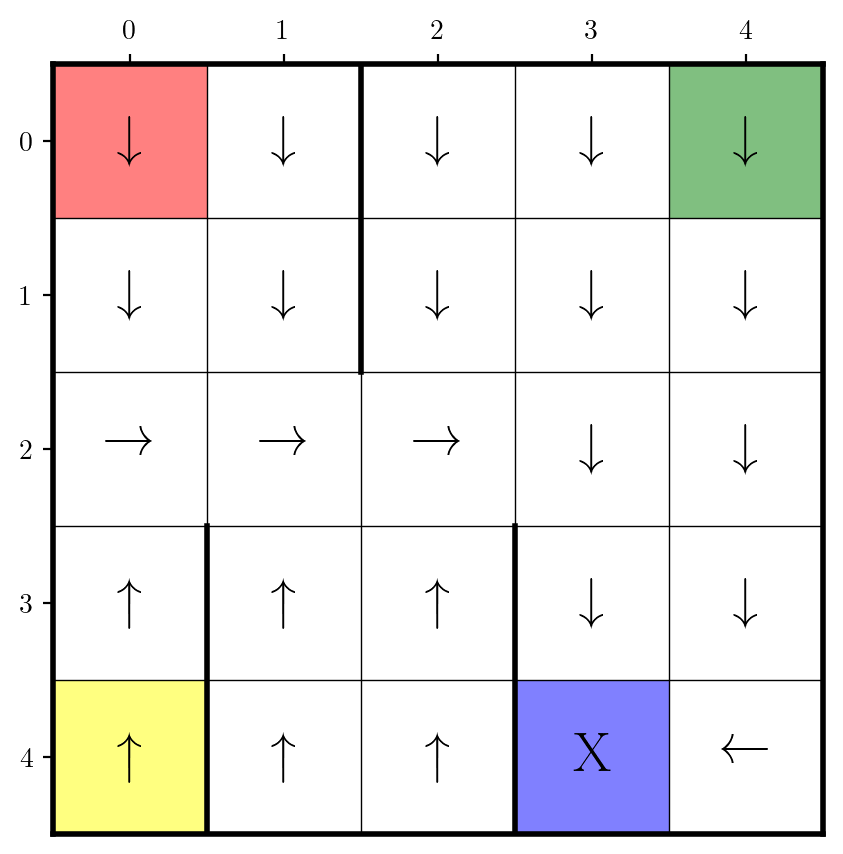

In [10]:
for goal in range(nO):
    plot_Q = Q_SMDP_Options[goal]
    get_grid()
    for i in range(nX):
        for j in range(nY):
            if i != targets[goal][0] or j != targets[goal][1]:
                action = np.argmax(plot_Q[i * nX + j])
                plt.text(j, i, actions_map[action], ha='center', va='center', fontsize=20)
            else:
                plt.text(j, i, "X", ha='center', va='center', fontsize=20)

# Intra-Option Q-Learning

In [11]:
Q_Intra = np.zeros((max_runs, nX * nY, nO + nA))
Q_Intra_Options = dict([(i, np.zeros((max_runs, nX * nY, nA - 2))) for i in range(nO)])

updates_Intra = []

run_rewards = []
for run in range(max_runs):

    episode_updates = []
    episode_rewards = []
    for episode in range(max_episodes):
        state = env.reset()
        done = False
        
        step_updates = []
        step_rewards = 0
        step = 0
        while not done:
            epsilon = max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * episode / max_episodes)

            substate_current = substate(state)
            action = egreedy_policy(Q_Intra[run], substate_current, epsilon=epsilon)

            if action in [0, 1, 2, 3, 4, 5]:
                substate_current = substate(state)

                next_state, reward, done, info = env.step(action)
                substate_next = substate(next_state)

                Q_Intra[run, substate_current, action] = Q_Intra[run, substate_current, action] + alpha * (reward + gamma * np.max(Q_Intra[run, substate_next]) - Q_Intra[run, substate_current, action])
                
                step_rewards += reward
                step_updates.append(step)
                step += 1

                state = next_state

            else:
                start = state
                substate_start = substate(start)
                goal = action - 6

                optrewards = []
                optdone, optsteps = False, 0

                while not optdone:
                    substate_current = substate(state)

                    optact, optdone = Option(env, state, Q_Intra_Options[goal][run], goal, epsilon=epsilon)
                    next_state, reward, done, info = env.step(optact)
                    next_x, next_y, _, _ = env.decode(next_state)
                    substate_next = substate(next_state)

                    if not optdone:
                        Q_Intra_Options[goal][run, substate_current, optact] = Q_Intra_Options[goal][run, substate_current, optact] + alpha * (reward + gamma * np.max(Q_Intra_Options[goal][run, substate_next]) - Q_Intra_Options[goal][run, substate_current, optact])

                    for G in range(nO):
                        if np.argmax(Q_Intra_Options[G][run, substate_next]) != optact and G != goal:
                            continue
                            
                        if next_x == targets[G][0] and next_y == targets[G][1]:
                            Q_Intra[run, substate_current, G + 6] = Q_Intra[run, substate_current, G + 6] + alpha * (reward + gamma * np.max(Q_Intra[run, substate_next]) - Q_Intra[run, substate_current, G + 6])
                        else:
                            Q_Intra[run, substate_current, G + 6] = Q_Intra[run, substate_current, G + 6] + alpha * (reward + gamma * Q_Intra[run, substate_next, G + 6] - Q_Intra[run, substate_current, G + 6])
                    
                    step_updates.append(step + optsteps)

                    optrewards.append(gamma**optsteps * reward)
                    optsteps += 1
                    state = next_state

                optrewards = sum(optrewards)
                step_rewards += optrewards
                step += optsteps


        episode_rewards.append(step_rewards)
        episode_updates.append(step_updates)

        clear_output(wait=True)
        print(f"Run: {run+1}/{max_runs}, Episode: {episode+1}/{max_episodes}: {step_rewards}")

    run_rewards.append(episode_rewards)
    updates_Intra.append(episode_updates)

Q_Intra = np.mean(Q_Intra, axis=0)
Q_Intra_Options = dict([(i, np.mean(Q_Intra_Options[i], axis=0)) for i in range(nO)])

Run: 5/5, Episode: 5000/5000: -96.79548000000003


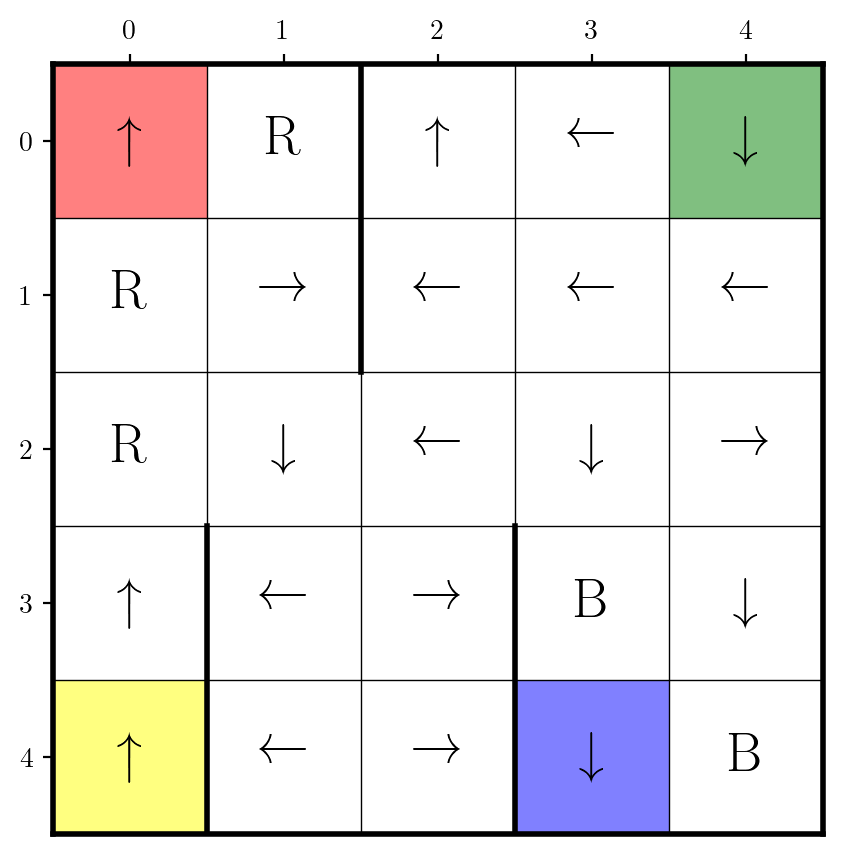

In [12]:
plot_Q = Q_Intra

get_grid()
for i in range(nX):
    for j in range(nY):
        action = np.argmax(plot_Q[i * nX + j])
        plt.text(j, i, actions_map[action], ha='center', va='center', fontsize=20)

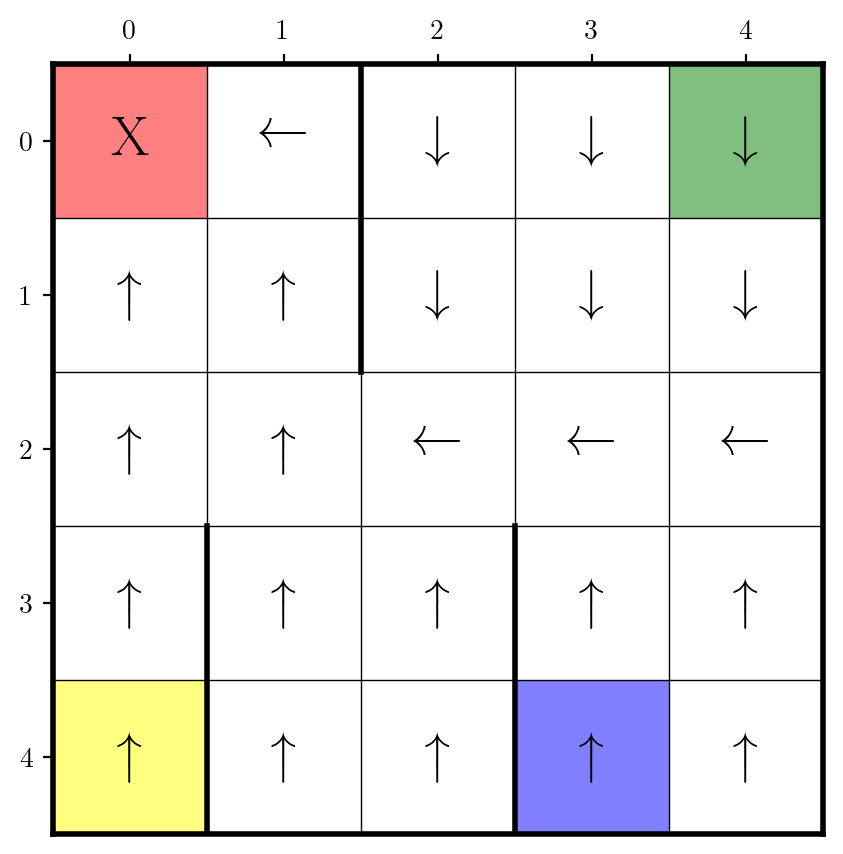

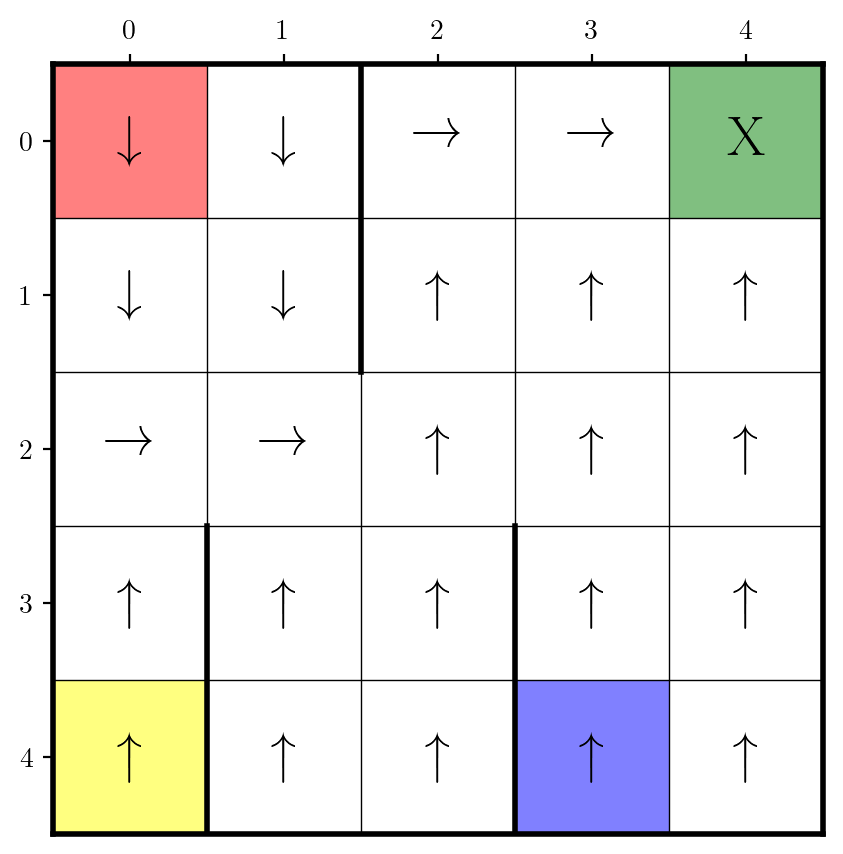

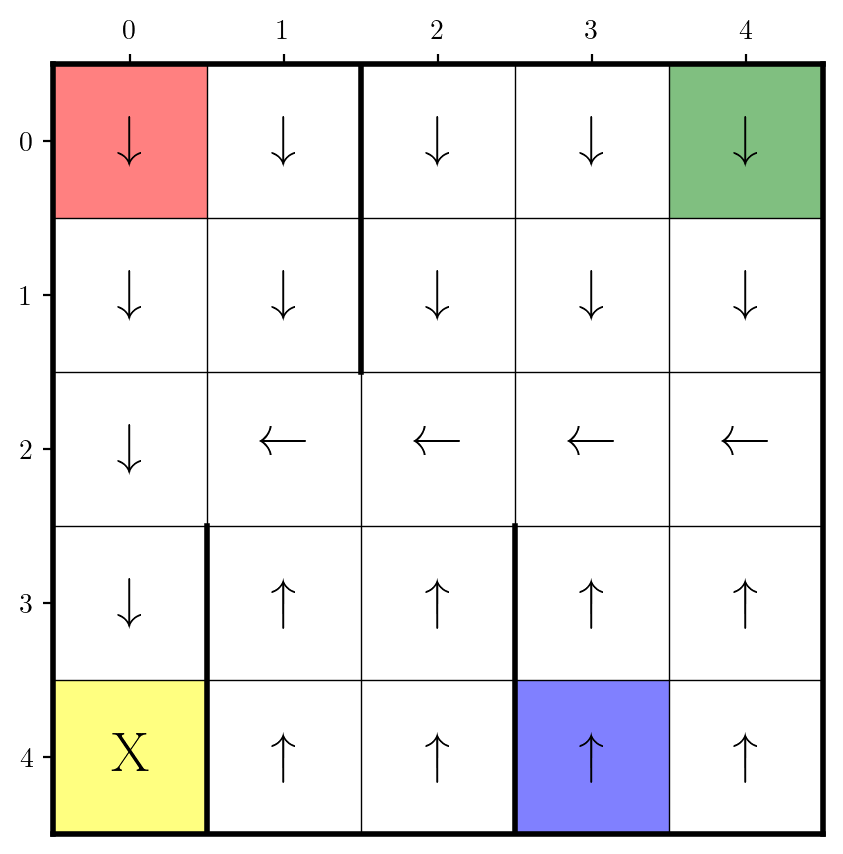

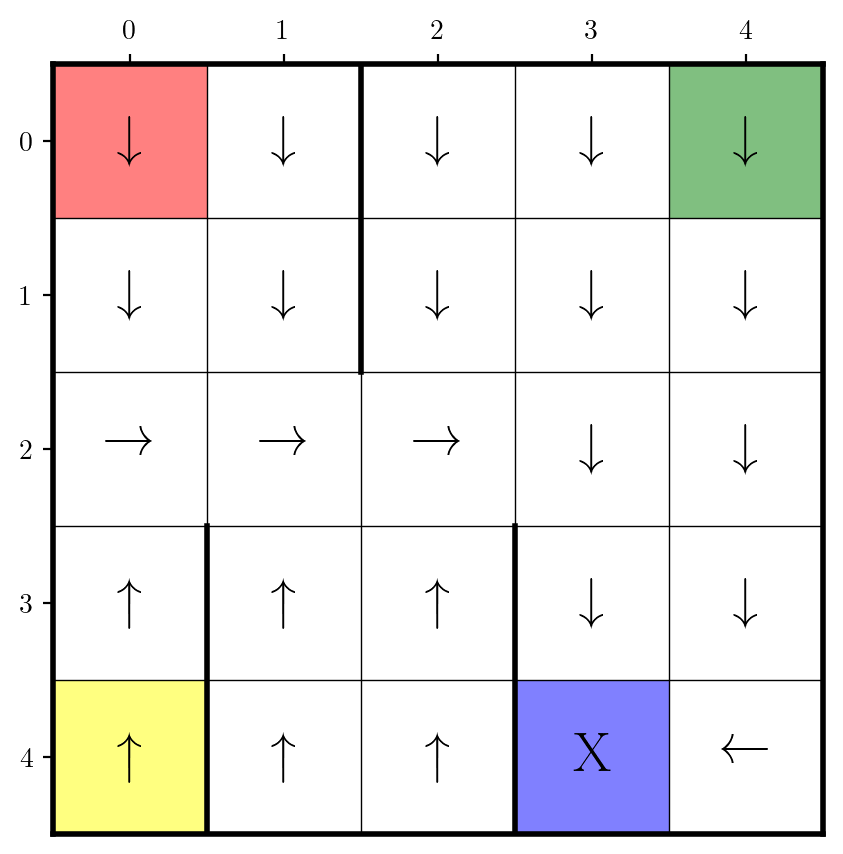

In [13]:
for goal in range(nO):
    plot_Q = Q_Intra_Options[goal]
    get_grid()
    for i in range(nX):
        for j in range(nY):
            if i != targets[goal][0] or j != targets[goal][1]:
                action = np.argmax(plot_Q[i * nX + j])
                plt.text(j, i, actions_map[action], ha='center', va='center', fontsize=20)
            else:
                plt.text(j, i, "X", ha='center', va='center', fontsize=20)